In [ ]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

In [ ]:
# obtain stock data from Yahoo Finance
# google, amazon, snapchat, apple, meta, nvidia, unity software, advanced micro devices, ford motor, tesla
all_data = {ticker: web.get_data_yahoo(ticker)
            for ticker in ['GOOG','AMZN','SNAP','AAPL','META','NVDA','U','AMD','F','TSLA']}

# obtain the price and volume from the stock data
price = pd.DataFrame({ticker: data['Adj Close']
                      for ticker, data in all_data.items()})
volume = pd.DataFrame({ticker: data['Volume']
                      for ticker, data in all_data.items()})

# combine the prices into a single variable
stocks = pd.concat([price['GOOG'], price['AMZN'], price['SNAP'], price['AAPL'], price['META'], price['NVDA'], price['U'], price['AMD'], price['F'], price['TSLA']
                   ], axis = 1)

# compute log return
log_return = np.log(stocks/stocks.shift(1))

In [ ]:
np.random.seed(42)
num_ports = 6000
num_stocks = 10
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

In [ ]:
for x in range(num_ports):
    # weights
    weights = np.array(np.random.random(num_stocks))
    weights = weights/np.sum(weights)

    # save weights
    all_weights[x,:] = weights

    # expected returns
    ret_arr[x] = np.sum((log_return.mean() * weights * 252))

    # expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))

    # sharpe ratio
    sharpe_arr[x] = ret_arr[x] / vol_arr[x]

# print max sharpe ratio
print("Maximum Sharpe ratio =", sharpe_arr.max())
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]

Maximum Sharpe ratio = 0.9087292546391852


In [ ]:
# print weights
print("Optimal weights:", all_weights[sharpe_arr.argmax(),:])

Optimal weights: [0.08417653 0.16967767 0.01769636 0.28536151 0.03267385 0.02008451
 0.0131112  0.12700131 0.02887954 0.22133752]


In [ ]:
def get_ret_vol_sr (weights):
    weights = np.array(weights)
    ret = np.sum(log_return.mean()*weights)*252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    # 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    # return 0 if sum of the weights is 1
    return np.sum(weights) - 1

cons = ({'type': 'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))
init_guess = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method = 'SLSQP', bounds = bounds, constraints = cons)

get_ret_vol_sr(opt_results.x)

# find best volatility
frontier_y = np.linspace(0, 0.35, 300)
frontier_x = []

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

for possible_return in frontier_y:
    cons = ({'type': 'eq', 'fun':check_sum},
           {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = minimize(minimize_volatility, init_guess, method = 'SLSQP', bounds = bounds, constraints = cons)
    frontier_x.append(result['fun'])

Respective efficient frontier:


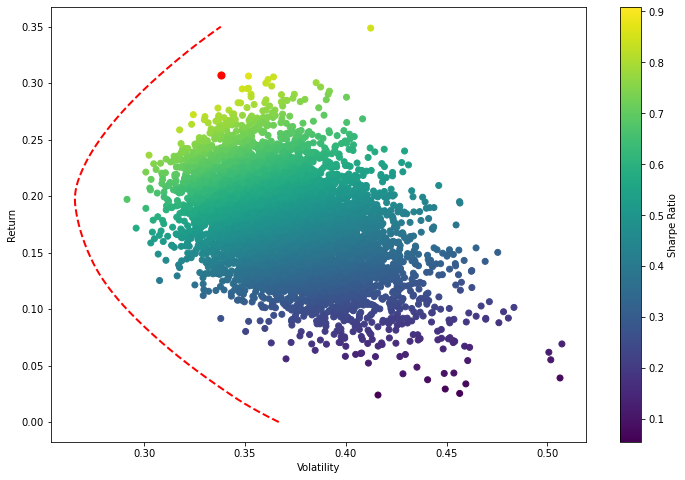

In [ ]:
# plot the efficient frontier
print('Respective efficient frontier:')
plt.figure(figsize = (12,8))
plt.scatter(vol_arr, ret_arr, c = sharpe_arr, cmap = 'viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret, c = 'red', s = 50)
plt.plot(frontier_x, frontier_y, 'r--', linewidth = 2)
plt.show()

In [ ]:
# find pairwise correlation
returns = price.pct_change()
print ("Correlation between stocks: \n", returns.corr())

Correlation between stocks: 
           GOOG      AMZN      SNAP      AAPL      META      NVDA         U  \
GOOG  1.000000  0.674737  0.377747  0.684781  0.682878  0.653785  0.430307   
AMZN  0.674737  1.000000  0.401441  0.643165  0.617176  0.627956  0.560945   
SNAP  0.377747  0.401441  1.000000  0.290469  0.423747  0.396594  0.527846   
AAPL  0.684781  0.643165  0.290469  1.000000  0.589998  0.652124  0.450717   
META  0.682878  0.617176  0.423747  0.589998  1.000000  0.583072  0.487611   
NVDA  0.653785  0.627956  0.396594  0.652124  0.583072  1.000000  0.540856   
U     0.430307  0.560945  0.527846  0.450717  0.487611  0.540856  1.000000   
AMD   0.512438  0.524403  0.306924  0.532377  0.445196  0.696266  0.472746   
F     0.380094  0.258579  0.181929  0.372004  0.325063  0.371898  0.227184   
TSLA  0.406424  0.416107  0.279768  0.459174  0.348555  0.466729  0.443531   

           AMD         F      TSLA  
GOOG  0.512438  0.380094  0.406424  
AMZN  0.524403  0.258579  0.416107  


In [ ]:
# find performance of stocks in previous week
print ("Past week performance of stocks: \n", returns.tail(7))

Past week performance of stocks: 
                 GOOG      AMZN      SNAP      AAPL      META      NVDA  \
Date                                                                     
2022-07-26 -0.025598 -0.052254 -0.032161 -0.008826 -0.045005 -0.028842   
2022-07-27  0.077390  0.053654 -0.008307  0.034235  0.065536  0.076030   
2022-07-28  0.008715  0.010829  0.012565  0.003572 -0.052247  0.010905   
2022-07-29  0.017890  0.103615  0.021717  0.032793 -0.010080  0.009953   
2022-08-01 -0.009945  0.003260 -0.034413 -0.006153  0.005217  0.015306   
2022-08-02  0.003637 -0.009085  0.034591 -0.009287  0.001626  0.004609   
2022-08-03  0.025798  0.040995  0.047619  0.037404  0.049195  0.016679   

                   U       AMD         F      TSLA  
Date                                                
2022-07-26 -0.056837 -0.026159 -0.023365 -0.035664  
2022-07-27  0.110382  0.053607  0.051834  0.061655  
2022-07-28  0.009404  0.020597  0.061410  0.022124  
2022-07-29 -0.004791  0.030544  0